# Analysis

Herman Kamper, 2024

In [1]:
from matplotlib.lines import Line2D
from numpy import linalg
from pathlib import Path
from praatio import textgrid
from tqdm import tqdm
import numpy as np
import sys
import torch
import torchaudio
import umap
import umap.plot
import matplotlib.pyplot as plt

sys.path.append("..")

from utils import fast_cosine_dist

device = "cuda"

In [2]:
source = "p279"
target = "p282"
utterance = "008"

## Features and labels

In [3]:
wavlm = torch.hub.load(
    "bshall/knn-vc", "wavlm_large", trust_repo=True, device=device
)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master
/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WavLM-Large loaded with 315,453,120 parameters.


In [4]:
wav_dir = Path("/home/kamperh/Dropbox/projects/speechssl/sandbox/mfa/vctk_subset/")
fa_dir = Path("/home/kamperh/Dropbox/projects/speechssl/sandbox/mfa/aligned/")

In [5]:
features_speaker = {}
phone_labels_speaker = {}

features_utt_speaker = {}
phone_labels_utt_speaker = {}

for speaker in [source, target]:
    
    features = []
    phone_labels = []

    for wav_fn in tqdm(sorted((wav_dir / speaker).glob("*.wav"))):
        # print(wav_fn)
        # print((fa_dir / speaker / wav_fn.stem).with_suffix(".TextGrid"))
        fa_fn = (fa_dir / speaker / wav_fn.stem).with_suffix(".TextGrid")

        # Features
        wav, _ = torchaudio.load(wav_fn)
        wav = wav.to(device)
        with torch.inference_mode():
            x, _ = wavlm.extract_features(wav, output_layer=6)
        x = x.cpu().numpy().squeeze()
        features.append(x)
    
        # Alignments
        cur_labels = []
        tg = textgrid.openTextgrid(fa_fn, includeEmptyIntervals=True)
        tier = tg.getTier("phones")
        for start, stop, label in tier.entries:
            # print("From:%f, To:%f, %s" % (start, stop, label))
            
            start = int(np.floor(start/0.02))
            stop = int(np.floor(stop/0.02))
    
            if label == "":
                label = "sil"
            if label[-1].isdigit():
                label = label[0:-1]
            
            cur_labels.extend([label,] * (stop - start))
            # print(start, min(start + stop - start, max_frames))
    
        cur_labels = cur_labels[:x.shape[0]]  # trim end

        # print(x.shape)
        # print(len(cur_labels))
    
        assert x.shape[0] == len(cur_labels)

        phone_labels.extend(cur_labels)

        if utterance in wav_fn.stem:
            features_utt_speaker[speaker] = np.float16(x)
            phone_labels_utt_speaker[speaker] = cur_labels

    features_speaker[speaker] = np.vstack(features, dtype=np.float16)
    phone_labels_speaker[speaker] = phone_labels

  0%|                                                                                         | 0/405 [00:00<?, ?it/s]/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1704987296916/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
100%|███████████████████████████████████████████████████████████████████████████████| 367/367 [00:07<00:00, 49.98it/s]


In [6]:
combined_data = np.vstack([
    features_speaker[source],
    features_speaker[target],
    features_utt_speaker[source],
    features_utt_speaker[target],
])
print("Data shape:", combined_data.shape)

Data shape: (92309, 1024)


In [7]:
speaker_labels = [
    [source] * features_speaker[source].shape[0],
    [target] * features_speaker[target].shape[0],
    [source] * features_utt_speaker[source].shape[0],
    [target] * features_utt_speaker[target].shape[0],
]
speaker_labels = np.array([item for row in speaker_labels for item in row])

In [8]:
phone_labels = [
    phone_labels_speaker[source],
    phone_labels_speaker[target],
    phone_labels_utt_speaker[source],
    phone_labels_utt_speaker[target],
]
phone_labels = np.array([item for row in phone_labels for item in row])

class_to_phones = {
    "Silence": ["sil", "spn"],
    "Fricative": ["CH", "JH", "S", "Z", "SH", "ZH", "F", "V", "TH", "DH", "HH"],
    "Stop": ["P", "B", "T", "D", "K", "G"],
    "Approximant": ["W", "R", "Y", "L"],
    "Nasal": ["M", "N", "NG"],
    "Vowel": ["IY", "UW", "IH", "UH", "EY", "AH", "EH", "OW", "AE", "ER", "AA", "AO", "AW", "AY", "OY"],
}
phones_to_class = {
    phone: group for group, phones in class_to_phones.items() for phone in phones
}
class_labels = np.array([phones_to_class[i] for i in phone_labels])

## UMAP

In [9]:
mapper = umap.UMAP(random_state=13).fit(combined_data)

/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

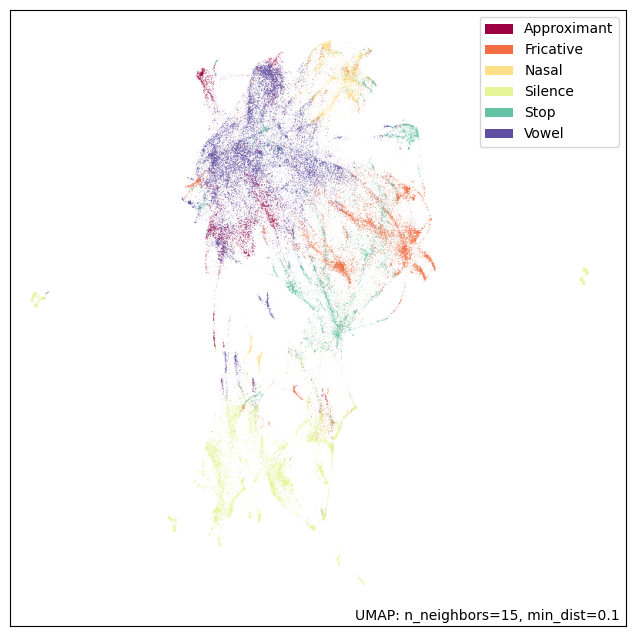

In [10]:
umap.plot.points(mapper, labels=class_labels)

### kNN-VC

In [11]:
k_top = 4

target_feats = torch.from_numpy(features_speaker[target]).float().to(device)
source_feats = torch.from_numpy(features_utt_speaker[source]).float().to(device)

dists = fast_cosine_dist(
    source_feats.squeeze(), target_feats, device=device
)
best = dists.topk(k=k_top, largest=False, dim=-1)
source_to_target_feats_knnvc = target_feats[best.indices].mean(dim=1)
source_to_target_feats_knnvc = source_to_target_feats_knnvc.cpu().numpy()

In [12]:
source_embeddings = mapper.transform(features_utt_speaker[source])
source_to_target_embeddings_knnvc = mapper.transform(source_to_target_feats_knnvc)

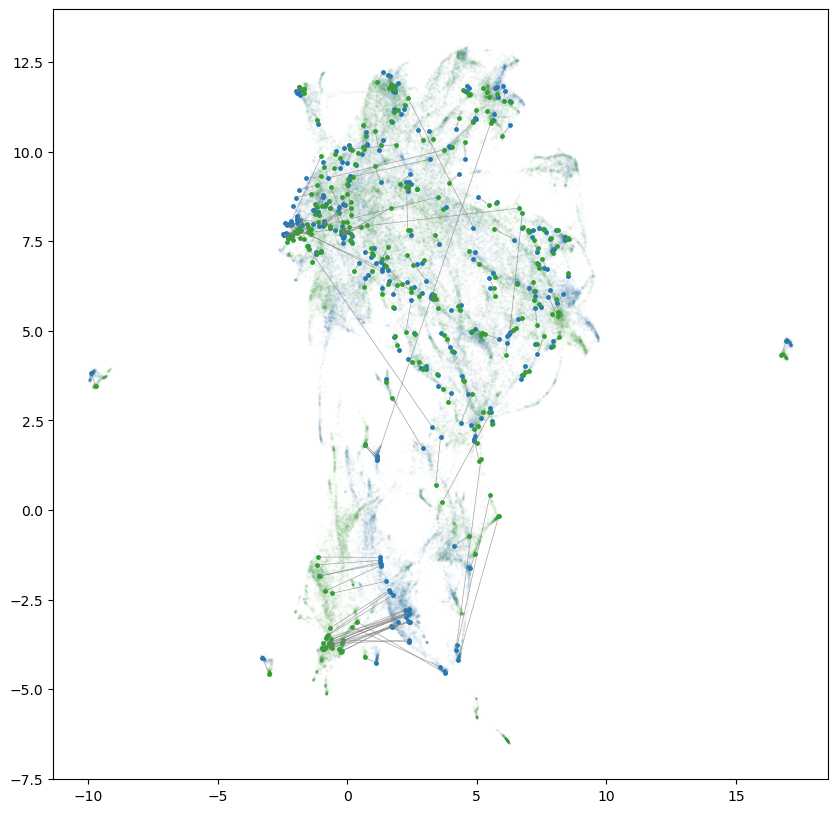

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

colour_list = []
for l in speaker_labels:
    if source in l:
        colour_list.append("C0")
    elif target in l:
        colour_list.append("C2")

ax.scatter(
    mapper.embedding_[:, 0], mapper.embedding_[:, 1], alpha=0.02, s=1,
    c=colour_list
)

ax.scatter(
    source_embeddings[:, 0],
    source_embeddings[:, 1],
    c="C0", s=6
)
ax.scatter(
    source_to_target_embeddings_knnvc[:, 0],
    source_to_target_embeddings_knnvc[:, 1],
    c="C2", s=6
)
for source_embed, target_embed in zip(
    source_embeddings, source_to_target_embeddings_knnvc
):
    ax.plot(
        [source_embed[0], target_embed[0]], [source_embed[1], target_embed[1]],
        "-", linewidth=0.5, alpha=0.7, c="tab:gray"
    )

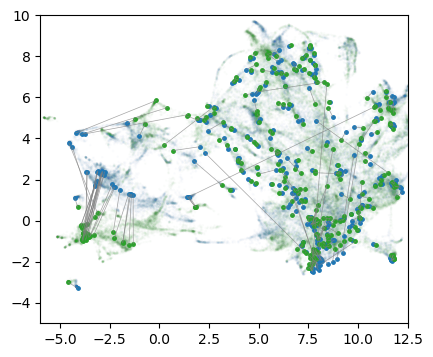

In [14]:
# For paper

columnwidth_in = 3.1614172222244096844
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt

fig, ax = plt.subplots(figsize=(columnwidth_in, 4))

colour_list = []
for l in speaker_labels:
    if source in l:
        colour_list.append("C0")
    elif target in l:
        colour_list.append("C2")

x = 1
y = 0

ax.scatter(
    mapper.embedding_[:, x], mapper.embedding_[:, y], alpha=0.01, s=1,
    c=colour_list
)

ax.scatter(
    source_embeddings[:, x],
    source_embeddings[:, y],
    c="C0", s=6
)
ax.scatter(
    source_to_target_embeddings_knnvc[:, x],
    source_to_target_embeddings_knnvc[:, y],
    c="C2", s=6
)
for source_embed, target_embed in zip(
    source_embeddings, source_to_target_embeddings_knnvc
):
    ax.plot(
        [source_embed[x], target_embed[x]], [source_embed[y], target_embed[y]],
        "-", linewidth=0.5, alpha=0.7, c="tab:gray"
    )

ax.set_xlim([-6, 12.5])
ax.set_ylim([-5, 10]);

### LinearVC

In [15]:
k_top = 1
n_frames = 8192

target_feats = torch.from_numpy(features_speaker[target][:n_frames, :]).float().to(device)
source_feats = torch.from_numpy(features_speaker[source][:n_frames, :]).float().to(device)

dists = fast_cosine_dist(
    source_feats.squeeze(), target_feats, device=device
)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())
W = torch.from_numpy(W).float().to(device)

source_feats = torch.from_numpy(features_utt_speaker[source]).float().to(device)
source_to_target_feats_linearvc = source_feats @ W
source_to_target_feats_linearvc = source_to_target_feats_linearvc.cpu().numpy()

/tmp/ipykernel_7905/1670435368.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())


In [16]:
source_to_target_embeddings_linearvc = mapper.transform(source_to_target_feats_linearvc)

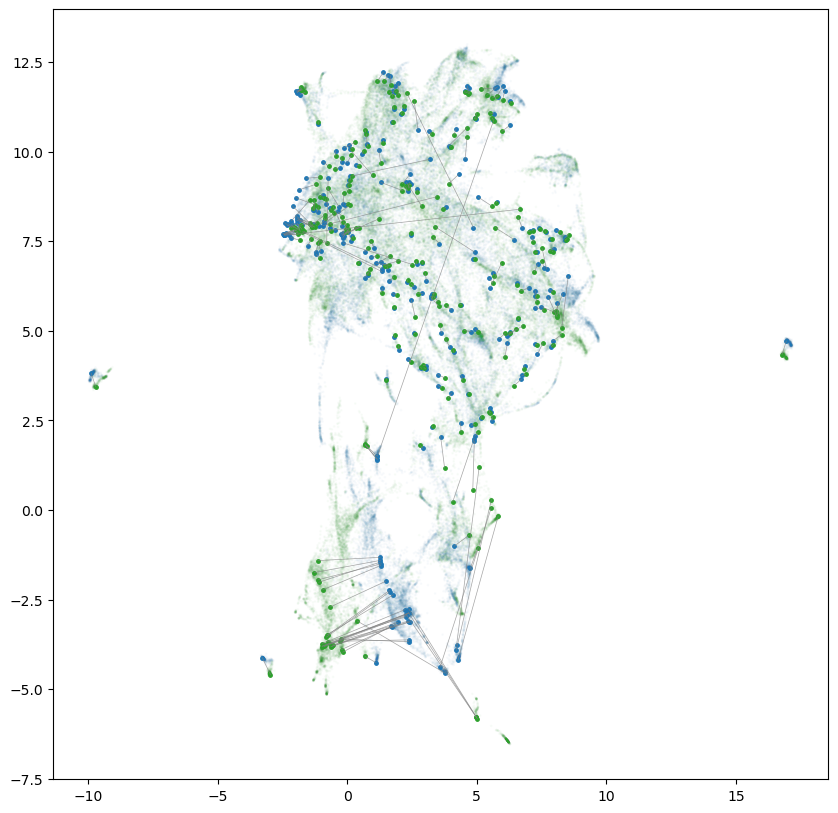

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

colour_list = []
for l in speaker_labels:
    if source in l:
        colour_list.append("C0")
    elif target in l:
        colour_list.append("C2")

ax.scatter(
    mapper.embedding_[:, 0], mapper.embedding_[:, 1], alpha=0.02, s=1,
    c=colour_list
)

ax.scatter(
    source_embeddings[:, 0],
    source_embeddings[:, 1],
    c="C0", s=6
)
ax.scatter(
    source_to_target_embeddings_linearvc[:, 0],
    source_to_target_embeddings_linearvc[:, 1],
    c="C2", s=6
)
for source_embed, target_embed in zip(
    source_embeddings, source_to_target_embeddings_linearvc
):
    ax.plot(
        [source_embed[0], target_embed[0]], [source_embed[1], target_embed[1]],
        "-", linewidth=0.5, alpha=0.7, c="tab:gray"
    )

### kNN-VC and LinearVC

In [18]:
np.random.seed(13)
idx = np.random.choice(source_embeddings.shape[0], size=150, replace=False)

source_embeddings_sample = source_embeddings[idx, :]
source_to_target_embeddings_knnvc_sample = source_to_target_embeddings_knnvc[idx, :]
source_to_target_embeddings_linearvc_sample = source_to_target_embeddings_linearvc[idx, :]

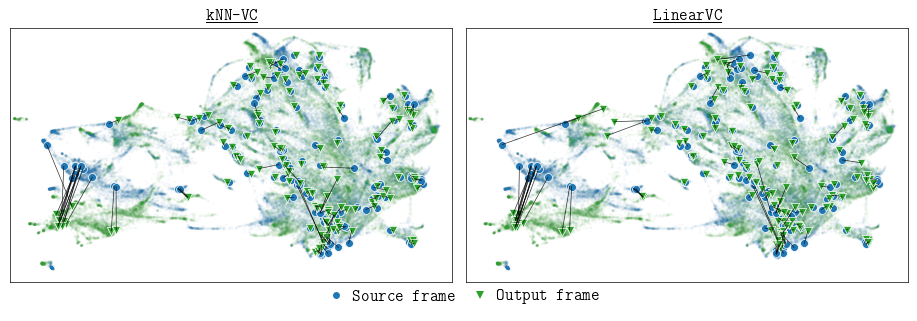

In [19]:
# For paper

plt.rcParams.update(
    {
        "figure.subplot.bottom": 0.08,
        "figure.subplot.left": 0.005,
        "figure.subplot.right": 0.995,
        "figure.subplot.top": 0.925,
        "font.family": "monospace",
        "font.size": 12,
        "legend.fontsize": "medium",
        "axes.titlesize": "medium",
        "text.usetex": True,
        "axes.linewidth": 0.5,
        "lines.linewidth": 1,
        "lines.markersize": 5,
        "lines.markeredgewidth": 0,
        "savefig.transparent": False,        
    }
)

columnwidth_in = 6.7180116667*0.9
columnwidth_in = columnwidth_in * 12 / 8  # 12pt font here should appear as 8pt
# umap_alpha = 0.01
# size_source = 12
# size_target = 15
# source_colour = "C0"
# target_colour = "C2"
# matching_line = 0.5

umap_alpha = 0.025
size_source = 32
size_target = 35
source_colour = "C0"
target_colour = "C2"
matching_line = 0.5

# umap_alpha = 0.05
# size_source = 5
# size_target = 6
# source_colour = "black"
# target_colour = "black"

fig, ax = plt.subplots(
    1,
    2, 
    figsize=(columnwidth_in, 3)
)

colour_list = []
for l in speaker_labels:
    if source in l:
        colour_list.append("C0")
    elif target in l:
        colour_list.append("C2")

x = 1
y = 0

# kNN-VC

ax[0].scatter(
    mapper.embedding_[:, x], mapper.embedding_[:, y], alpha=umap_alpha, s=1,
    c=colour_list
)

ax[0].scatter(
    source_embeddings_sample[:, x],
    source_embeddings_sample[:, y],
    c=source_colour, s=size_source, marker="o", edgecolors="white", linewidths=0.5
)

ax[0].scatter(
    source_to_target_embeddings_knnvc_sample[:, x],
    source_to_target_embeddings_knnvc_sample[:, y],
    c=target_colour, s=size_target, marker="v", edgecolors="white", linewidths=0.5
)
for source_embed, target_embed in zip(
    source_embeddings_sample, source_to_target_embeddings_knnvc_sample
):
    ax[0].plot(
        [source_embed[x], target_embed[x]], [source_embed[y], target_embed[y]],
        "-", linewidth=matching_line, alpha=0.8, c="black", #zorder=-10
    )

ax[0].set_xlim([-6, 13.5])
ax[0].set_ylim([-4, 10])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title(r"\underline{kNN-VC}")
# ax[0].set_axis_off()

# LinearVC

ax[1].scatter(
    mapper.embedding_[:, x], mapper.embedding_[:, y], alpha=umap_alpha, s=1,
    c=colour_list
)

ax[1].scatter(
    source_embeddings_sample[:, x],
    source_embeddings_sample[:, y],
    c=source_colour, s=size_source, marker="o", edgecolors="white", linewidths=0.5
)

ax[1].scatter(
    source_to_target_embeddings_linearvc_sample[:, x],
    source_to_target_embeddings_linearvc_sample[:, y],
    c=target_colour, s=size_target, marker="v", edgecolors="white", linewidths=0.5
)
for source_embed, target_embed in zip(
    source_embeddings_sample, source_to_target_embeddings_linearvc_sample
):
    ax[1].plot(
        [source_embed[x], target_embed[x]], [source_embed[y], target_embed[y]],
        "-", linewidth=matching_line, alpha=0.8, c="black"
    )

ax[1].set_xlim([-6, 13.5])
ax[1].set_ylim([-4, 10])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(r"\underline{LinearVC}")
# ax[1].set_axis_off()

markers = [
    Line2D(
        [0], [0], color="tab:blue", marker="o", linestyle="None", markersize=5
    ),
    Line2D(
        [0], [0], color="tab:green", marker="v", linestyle="None", markersize=6
    ),
]
# legend = fig.legend(
#     markers,
#     ["Source frame", "Output frame"],
#     # ncols=2,
#     # frameon=False,
#     fancybox=False,
#     shadow=False,
#     loc="upper left",
#     # bbox_to_anchor=(0.5, -0.02),
#     # edgecolor="black"
# )
legend = fig.legend(
    markers,
    ["Source frame", "Output frame"],
    ncols=2,
    frameon=False,
    fancybox=False,
    shadow=False,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.045),
    # loc="lower right",
    # bbox_to_anchor=(1.0, -0.045),
    # edgecolor="black"
    handletextpad=0,
    columnspacing=0.5
)
# legend.get_frame().set_linewidth(0.5)

plt.subplots_adjust(wspace=0.03)

# plt.savefig("umap.png", dpi=300)
plt.savefig("umap.png", dpi=300)
# plt.savefig("umap.pdf")

## UMAP on vowels only

In [20]:
filtered_combined_data = []
filtered_speaker_labels = []
filtered_phone_labels = []

for i, class_label in enumerate(class_labels):
    if class_label == "Vowel":
        filtered_combined_data.append(combined_data[i, :])
        filtered_speaker_labels.append(speaker_labels[i])
        filtered_phone_labels.append(phone_labels[i])

filtered_combined_data = np.vstack(filtered_combined_data)

In [21]:
mapper_vowels = umap.UMAP(random_state=13).fit(filtered_combined_data)

/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

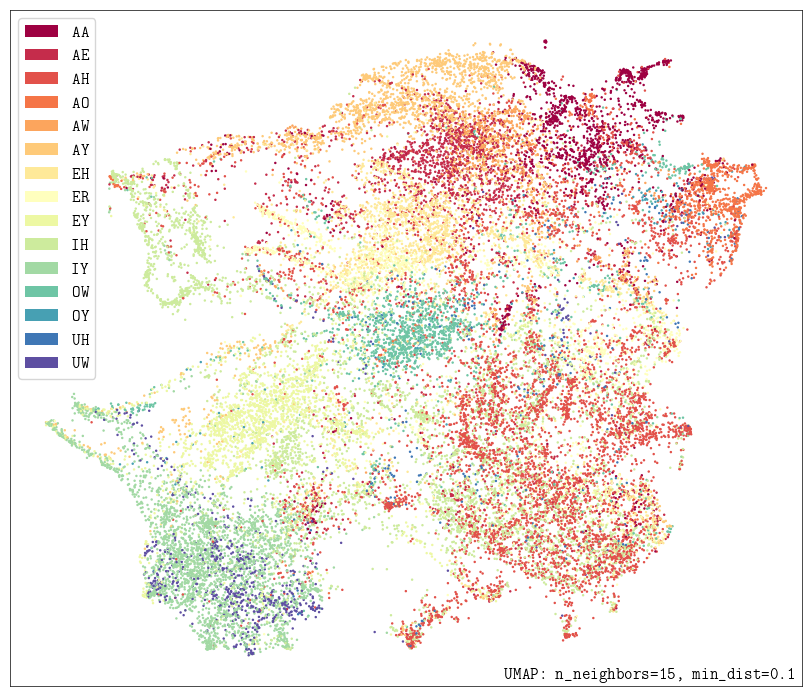

In [22]:
umap.plot.points(mapper_vowels, labels=np.array(filtered_phone_labels))

### kNN-VC

In [23]:
k_top = 4

target_feats = torch.from_numpy(features_speaker[target]).float().to(device)
source_feats = torch.from_numpy(features_utt_speaker[source]).float().to(device)

dists = fast_cosine_dist(
    source_feats.squeeze(), target_feats, device=device
)
best = dists.topk(k=k_top, largest=False, dim=-1)
source_to_target_feats = target_feats[best.indices].mean(dim=1)
source_to_target_feats = source_to_target_feats.cpu().numpy()

In [24]:
filtered_source_feat = []
filtered_source_to_target_feats = []
for i, label in enumerate(phone_labels_utt_speaker[source]):
    if phones_to_class[label] == "Vowel":
        filtered_source_feat.append(features_utt_speaker[source][i, :])
        filtered_source_to_target_feats.append(source_to_target_feats[i, :])
filtered_source_feat = np.array(filtered_source_feat)        
filtered_source_to_target_feats = np.array(filtered_source_to_target_feats)        

In [25]:
filtered_source_embeddings = mapper_vowels.transform(filtered_source_feat)
filtered_source_to_target_embeddings_knnvc = mapper_vowels.transform(filtered_source_to_target_feats)

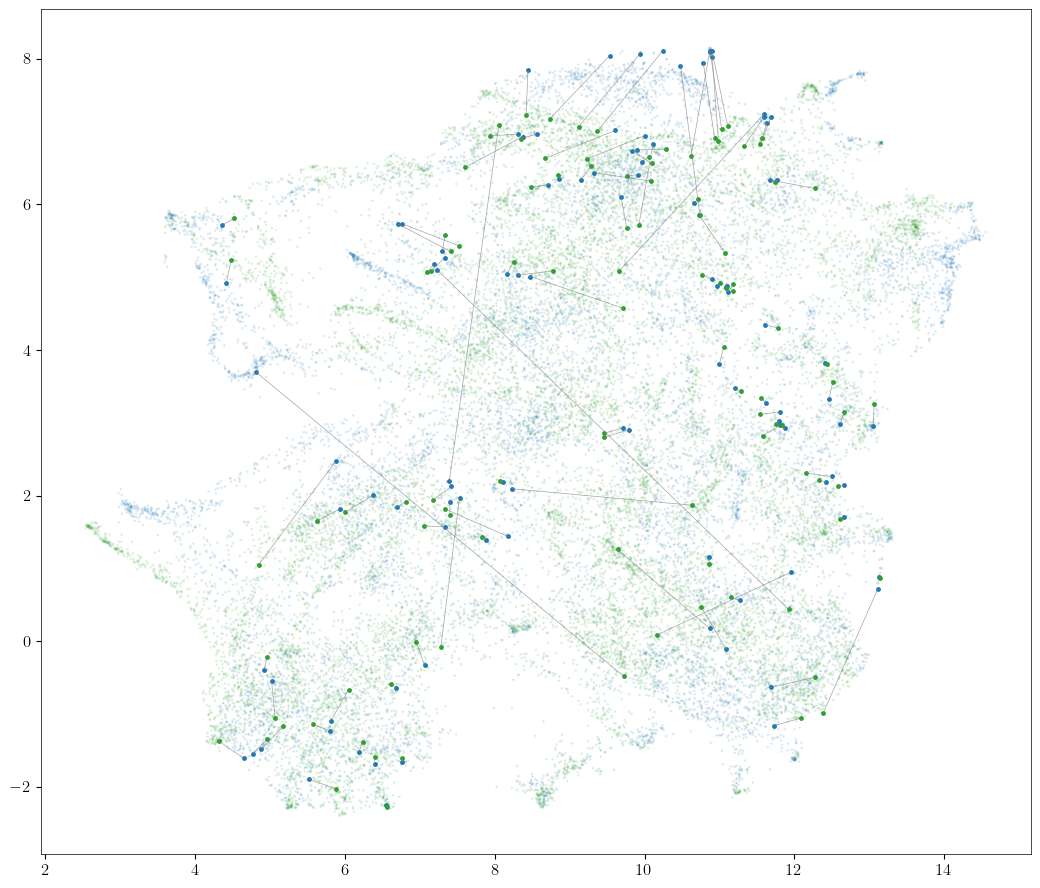

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

colour_list = []
for l in filtered_speaker_labels:
    if source in l:
        colour_list.append("C0")
    elif target in l:
        colour_list.append("C2")

ax.scatter(
    mapper_vowels.embedding_[:, 0], mapper_vowels.embedding_[:, 1], alpha=0.1, s=1,
    c=colour_list
)

ax.scatter(
    filtered_source_embeddings[:, 0],
    filtered_source_embeddings[:, 1],
    c="C0", s=6
)
ax.scatter(
    filtered_source_to_target_embeddings_knnvc[:, 0],
    filtered_source_to_target_embeddings_knnvc[:, 1],
    c="C2", s=6
)
for source_embed, target_embed in zip(
    filtered_source_embeddings, filtered_source_to_target_embeddings_knnvc
):
    ax.plot(
        [source_embed[0], target_embed[0]], [source_embed[1], target_embed[1]],
        "-", linewidth=0.5, alpha=0.7, c="tab:gray"
    )

### LinearVC

In [27]:
k_top = 1
n_frames = 8192

target_feats = (
    torch.from_numpy(features_speaker[target][:n_frames, :]).float().to(device)
)
source_feats = (
    torch.from_numpy(features_speaker[source][:n_frames, :]).float().to(device)
)

dists = fast_cosine_dist(source_feats.squeeze(), target_feats, device=device)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())
W = torch.from_numpy(W).float().to(device)

source_feats = torch.from_numpy(features_utt_speaker[source]).float().to(device)
source_to_target_feats_linearvc = source_feats @ W
source_to_target_feats_linearvc = source_to_target_feats_linearvc.cpu().numpy()


/tmp/ipykernel_7905/3290374936.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())


In [28]:
filtered_source_to_target_feats_linearvc = []
for i, label in enumerate(phone_labels_utt_speaker[source]):
    if phones_to_class[label] == "Vowel":
        filtered_source_to_target_feats_linearvc.append(
            source_to_target_feats_linearvc[i, :]
        )
filtered_source_to_target_feats_linearvc = np.array(
    filtered_source_to_target_feats_linearvc
)

filtered_source_to_target_embeddings_linearvc = mapper_vowels.transform(
    filtered_source_to_target_feats_linearvc
)

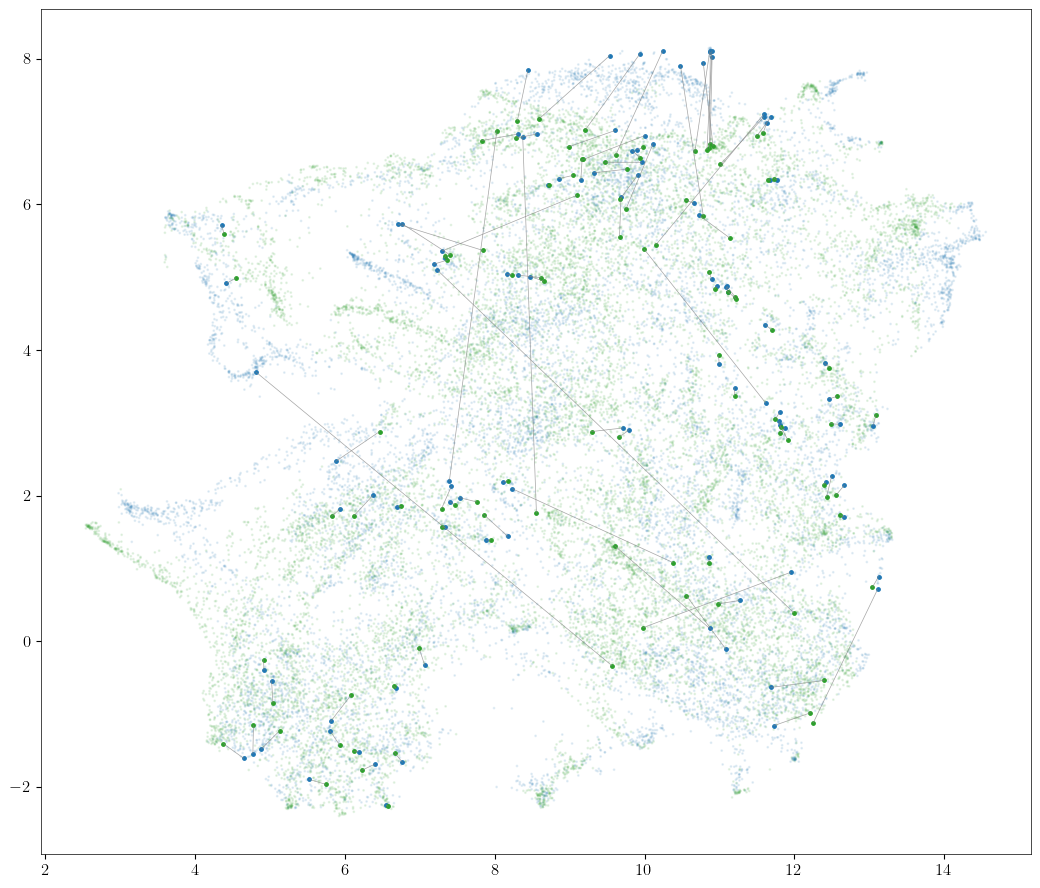

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))

colour_list = []
for l in filtered_speaker_labels:
    if source in l:
        colour_list.append("C0")
    elif target in l:
        colour_list.append("C2")

ax.scatter(
    mapper_vowels.embedding_[:, 0],
    mapper_vowels.embedding_[:, 1],
    alpha=0.1,
    s=1,
    c=colour_list,
)

ax.scatter(
    filtered_source_embeddings[:, 0],
    filtered_source_embeddings[:, 1],
    c="C0",
    s=6,
)
ax.scatter(
    filtered_source_to_target_embeddings_linearvc[:, 0],
    filtered_source_to_target_embeddings_linearvc[:, 1],
    c="C2",
    s=6,
)
for source_embed, target_embed in zip(
    filtered_source_embeddings, filtered_source_to_target_embeddings_linearvc
):
    ax.plot(
        [source_embed[0], target_embed[0]],
        [source_embed[1], target_embed[1]],
        "-",
        linewidth=0.5,
        alpha=0.7,
        c="tab:gray",
    )
